In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import ast
import json

from scipy.stats import randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from joblib import dump, load
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data_path = 'data/projdata'
metadata = pd.read_csv(os.path.join(data_path, 'movies_metadata.csv'), low_memory=False)

def convert_metadata(metadata):
    metadata['release_date'] = pd.to_datetime(metadata['release_date'], errors='coerce')
    metadata['budget'] = pd.to_numeric(metadata['budget'], errors='coerce')
    metadata['revenue'] = pd.to_numeric(metadata['revenue'], errors='coerce')
    metadata['runtime'] = pd.to_numeric(metadata['runtime'], errors='coerce')
    return metadata

metadata = convert_metadata(metadata)

metadata = metadata[pd.notnull(metadata['title'])]
metadata = metadata[pd.notnull(metadata['budget'])]
metadata = metadata[pd.notnull(metadata['revenue'])]
metadata = metadata[pd.notnull(metadata['runtime'])]
metadata = metadata[pd.notnull(metadata['release_date'])]
metadata = metadata[pd.notnull(metadata['overview'])]

metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').dt.year.astype('Int64')
metadata['genre_list'] = metadata['genres'].apply(lambda x: [genre['name'] for genre in ast.literal_eval(x)])
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44435 entries, 0 to 45465
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  44435 non-null  object        
 1   belongs_to_collection  4429 non-null   object        
 2   budget                 44435 non-null  float64       
 3   genres                 44435 non-null  object        
 4   homepage               7749 non-null   object        
 5   id                     44435 non-null  object        
 6   imdb_id                44423 non-null  object        
 7   original_language      44425 non-null  object        
 8   original_title         44435 non-null  object        
 9   overview               44435 non-null  object        
 10  popularity             44435 non-null  object        
 11  poster_path            44128 non-null  object        
 12  production_companies   44435 non-null  object        
 13  produc

In [3]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(metadata['genre_list'])
label_classes = mlb.classes_

label_classes
label_list = []
for elem in label_classes:
  label_list.append(elem)

final_genres = MultiLabelBinarizer(classes = label_list) 
y = final_genres.fit_transform(metadata['genre_list'])
final_genres.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [4]:
X = metadata['title']
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

vectorizer = TfidfVectorizer(stop_words = 'english', lowercase = True)

X_train_vector = vectorizer.fit_transform(X_train)
X_val_vector = vectorizer.transform(X_val)

(35548,) (8887,) (35548, 20) (8887, 20)


In [5]:
def pipeline(model, params = None, cv = 5):
    if params == None:
        model.fit(X_train_vector, y_train)
        return(model, model.predict(X_train_vector), model.predict(X_val_vector))
    else:
        model_cv = GridSearchCV(estimator = model, param_grid = params, cv = cv)
        model_cv.fit(X_train_vector, y_train)
        model = model_cv.best_estimator_

        train_preds = model.predict(X_train_vector)
        val_preds = model.predict(X_val_vector)

        results_df = pd.DataFrame(model_cv.cv_results_)
            
        return(model, train_preds, val_preds, model_cv, results_df)

In [6]:
tree = DecisionTreeClassifier()

param_dist = {
    'max_depth': [None, 20, 40, 80, 160, 320],  # The maximum depth of the tree. If None, then nodes are expanded until all leaves contain less than min_samples_split samples
    'min_samples_split': [2, 5, 10, 15, 20],  # default = 2
    'min_samples_leaf': [1, 5, 10, 15, 20],  # default = 1
    'max_features': ['sqrt', 'log2', None]  # default = None
}


model, train_preds, val_preds, tree_random_search, results_df = pipeline(tree, param_dist)

target_names = label_list
training_report = classification_report(y_true=y_train, y_pred=train_preds, target_names=target_names)
validation_report = classification_report(y_true=y_val, y_pred=val_preds, target_names=target_names)
train_accuracy = accuracy_score(y_true=y_train, y_pred=train_preds)
validation_accuracy = accuracy_score(y_true=y_val, y_pred=val_preds)
print("Best hyperparameters:", tree_random_search.best_params_)  # Print the best hyperparameters
print("\nClassification Report - Training:\n", training_report)
print("\nClassification Report - Validation:\n", validation_report)
print("\nAccuracy - Training:", train_accuracy)
print("Accuracy - Validation:", validation_accuracy)

KeyboardInterrupt: 

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_min_samples_leaf',
       'param_min_samples_split', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')


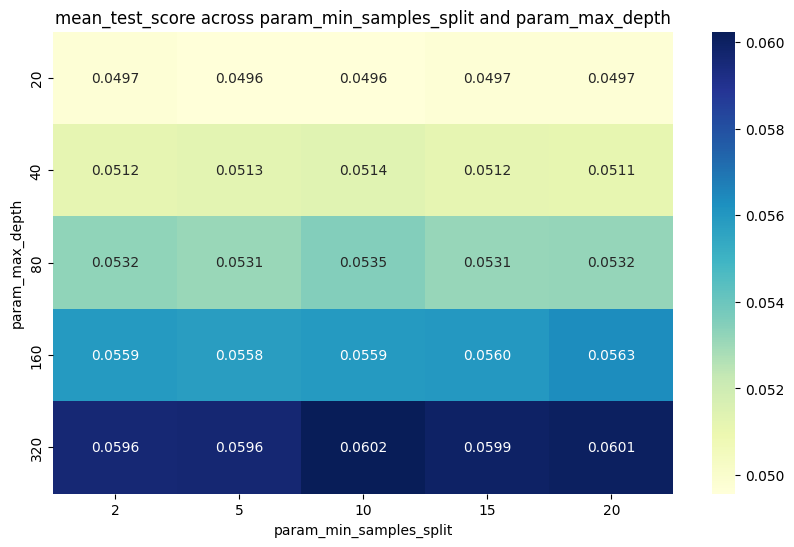

In [ ]:
def plot_results(results_df, param1, param2, metric):
    print(results_df.columns)
    pivot_table = results_df.pivot_table(index=param2, columns=param1, values=metric)
    plt.figure(figsize=(10, 6))
    plt.title(f'{metric} across {param1} and {param2}')
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.show()

plot_results(results_df, 'param_min_samples_split', 'param_max_depth', 'mean_test_score')

# plotting heatmap of max depth & minimum samples per split

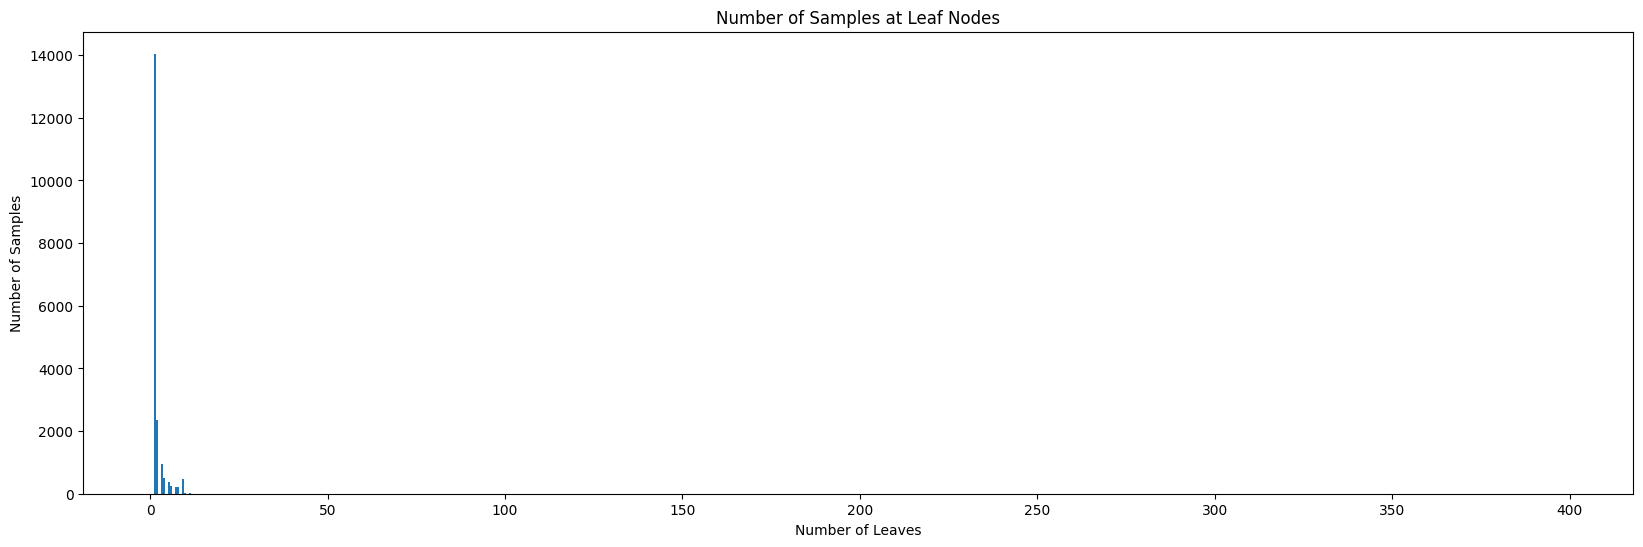

In [ ]:
# plotting number of samples per leaf
# shows overfitting
def plot_no_samples(model):
    plt.figure(figsize=(20, 6))
    plt.title("Number of Samples at Leaf Nodes")
    plt.hist(model.tree_.n_node_samples[model.tree_.children_left == -1], bins=600)
    plt.xlabel("Number of Leaves")
    plt.ylabel("Number of Samples")
    plt.show()


plot_no_samples(model)